<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialisation" data-toc-modified-id="Initialisation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialisation</a></span></li><li><span><a href="#Data-inspection" data-toc-modified-id="Data-inspection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data inspection</a></span></li><li><span><a href="#Correction-of-sample-drifts" data-toc-modified-id="Correction-of-sample-drifts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Correction of sample drifts</a></span><ul class="toc-item"><li><span><a href="#Interactive" data-toc-modified-id="Interactive-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Interactive</a></span></li><li><span><a href="#Linear-interpolation" data-toc-modified-id="Linear-interpolation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Linear interpolation</a></span></li><li><span><a href="#Shift-the-raw-data" data-toc-modified-id="Shift-the-raw-data-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Shift the raw data</a></span></li></ul></li><li><span><a href="#Transformation-from-angular-to-reciprocal-space" data-toc-modified-id="Transformation-from-angular-to-reciprocal-space-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Transformation from angular to reciprocal space</a></span></li><li><span><a href="#Determination-of-a-VOI-in-reciprocal-space" data-toc-modified-id="Determination-of-a-VOI-in-reciprocal-space-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Determination of a VOI in reciprocal space</a></span></li><li><span><a href="#Calculation-and-visualisation-of-local-structural-parameters" data-toc-modified-id="Calculation-and-visualisation-of-local-structural-parameters-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calculation and visualisation of local structural parameters</a></span><ul class="toc-item"><li><span><a href="#COMs" data-toc-modified-id="COMs-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>COMs</a></span></li><li><span><a href="#Gaussian-fitting-(with-XSOCS)" data-toc-modified-id="Gaussian-fitting-(with-XSOCS)-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Gaussian fitting (with XSOCS)</a></span></li></ul></li></ul></div>

This notebook exposes the data analysis pipeline needed to obtain the local:

* peak intensity
* interplanar distance
* tilt

from a typical 5D-SXDM measurement performed on beamline ID01 @ ESRF. 

A 5D-SXDM measurement is defined as the output of a `dsxdm_3D()` BLISS command, and corresponds to a series of `dsxdm()` scans - i.e., to a series of SXDM maps taken at different incidence angles of the X-ray beam. Each map results from a raster scan of a chosen sample area relative to the focussed beam. At each beam position, a detector frame is collected. Thus, raw data from a single SXDM map is in the form $I(x, y, \mathsf{detX}, \mathsf{detY})$, where $I$ is the scattered intensity, $(x, y)$ are the positions of the sample relative to the beam, and $(\mathsf{detX}, \mathsf{detY})$ are the horizontal and vertical directions of the 2D detector active area.

A 5D-SXDM dataset is therefore 5-dimensional, its data being in the form $I(x, y, \eta, \mathsf{detX}, \mathsf{detY})$, where $\eta$ is the incidence (or rocking) angle. This notebook processes the raw data so that a linear transformation from angular to reciprocal space coordinates is performed, i.e.:

$$ I(x, y, \eta, \mathsf{detX}, \mathsf{detY}) \to I(x, y, q_x, q_y, q_z) $$

This transformation requires knowledge of the diffractometer geometry and angles (not simply $\eta$), and to interpolate data on an orthogonal grid. From $I(x, y, q_x, q_y, q_z)$ one can then compute the centre of mass of the intensity as a function of sample position, obtaining $\vec{q}(x, y)$. This allows one to finally compute the local structural parameters listed above.

<div class="alert alert-block alert-info">
<b>Note:</b> Jupyter notebooks run on <code>IPython</code>, meaning that one can inspect the docstring of an <code>object</code> by using the syntax <code>object?</code>. Don't hesitate to explore the functionality of the code below beyond this notebook by inspecting docstrings!
</div>

Some useful links:
* [Jupyter notebook basics](https://nbviewer.org/github/jupyter/notebook/blob/main/docs/source/examples/Notebook/Notebook%20Basics.ipynb)
* [ID01 Confluence](https://confluence.esrf.fr/display/BLID01KB)
* [id01-science](https://gitlab.esrf.fr/id01-science) group of GitLab repositories

# Initialisation 

Import Python libraries needed to run the notebook:

In [1]:
%matplotlib widget

import sxdm
import id01lib
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h5py
import hdf5plugin
import ipywidgets as ipw
import scipy.ndimage as ndi
import xrayutilities as xu

from h5glance import H5Glance as h5p
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rcParams["image.origin"] = "lower"
mpl.rcParams["font.family"] = "Liberation Sans"
mpl.rcParams["figure.dpi"] = 100

/mnt/multipath-shares/data/id01/inhouse/data_analysis/software/pyenvs/sxdm.slurm/lib/python3.8/site-packages/silx/io/h5py_utils.py:50: H5pyDeprecationWarning: h5py.get_config().swmr_min_hdf5_version is deprecated. This version of h5py does not support older HDF5 without SWMR.
  HDF5_SWMR_VERSION = calc_hexversion(*h5py.get_config().swmr_min_hdf5_version[:3])


# Data inspection

First the **experiment** directory is specified:

In [2]:
path_exp = './data/MA1234/id01/20230710'

This is a mock directory containing a **sample** called `sample`:

In [3]:
ls -l {path_exp}

total 8
drwxr-xr-x 3 zatterin id01 4096 Jul 10  2023 sample/
drwxr-xr-x 2 zatterin id01 4096 Nov 13 19:02 sample_analysis/


In reality the experiment directory will likely contain multiple sample directories to choose fom. The variable `name_sample` is modified below to match a chosen sample, and list its contents:

In [4]:
name_sample = 'sample'

!tree {path_exp}/{name_sample} -L 2

./data/MA1234/id01/20230710/sample
└── sample_0001
    ├── sample_0001.h5
    ├── scan0001
    ├── scan0002
    ├── scan0003
    ├── scan0004
    └── scan0005

6 directories, 1 file


The subfolder above corresponds to a specific **dataset** associated with the chosen sample. Once more, during a real experiment one normally obtains multiple datasets and therefore multiple directories are generated. A dataset can be chosen by simply specifying its number:

In [5]:
name_dset = '0001'
path_dset = f'{path_exp}/{name_sample}/{name_sample}_{name_dset}/{name_sample}_{name_dset}.h5'

In [6]:
path_dset

'./data/MA1234/id01/20230710/sample/sample_0001/sample_0001.h5'

and its contents inspected using the `InspectROI` widget. This widget allows one to plot the spatial distribution of a selected counter, i.e. of some quantity that has been measured at each $(x,y)$ SXDM scan position during the experiment. These are most often detector regions of interest (ROIs). The widget also allows to look at the motor positions that were present during the selected scan.

> * **motors**: things that can be moved 
> * **counters** : things that are measured at each point of a scan

In [7]:
viz = sxdm.widgets.bliss.InspectSXDMCounter(path_dset, default_counter='mpx1x4_mpx4int')
viz.show()

It is useful to specify the scan numbers of interest (these are sometimes only a subset of a dataset):

In [8]:
scan_nums = [f"{x}.1" for x in range(1, 6)]

# Correction of sample drifts 

Once one is happy with the *dataset* choice, one proceeds to check if the data has to be corrected for **sample drifts**. That is, if the scanned area (the field of view, or FoV) has moved for increasing values of the incidence angle during the rocking curve. This may happen if the sample is not quite sitting at the centre of rotation of the diffractometer.

To estimate the movement of the FoV with angle for a chosen `path_dset` and `scan_nums` one can use the `get_shift` function. This uses [`skimage.registration.phase_cross_correlation`](https://scikit-image.org/docs/stable/api/skimage.registration.html#skimage.registration.phase_cross_correlation) to estimate the shift between two similar images by looking at cross-correlations in Fourier space. 

> The `get shift` function thus accepts keyword arguments from `phase_cross_correlation` - `reference_mask` being often a useful one (see below). 

Start by choosing `mpx1x4_mpx4int` as the signal to track between different SXDM maps as it is visible at all angles:

In [9]:
# mask is True for data that is considered in shift estimation
mask = np.zeros(sxdm.io.bliss.get_scan_shape(path_dset, '1.1')).astype('bool')
mask[30:, 30:] = True

# load raw maps
sxdm_raw = [sxdm.io.bliss.get_counter_sxdm(path_dset, s, 'mpx1x4_mpx4int') for s in scan_nums]

# estimate shift bewtween successive images
shifts = sxdm.utils.get_shift(
    sxdm_raw,
    med_filt=(3,3),
    reference_mask=mask, # if mask used, upsample_factor is ignored
    upsample_factor=5
)

# shift raw maps
sxdm_shift = [ndi.shift(m, s, cval=np.nan) for m, s in zip(sxdm_raw, shifts)]

  0%|          | 0/4 [00:00<?, ?it/s]

/mnt/multipath-shares/data/id01/inhouse/data_analysis/software/pyenvs/sxdm.slurm/lib/python3.8/site-packages/sxdm/utils/general.py:198: FutureWarning: In scikit-image 0.22, phase_cross_correlation will start returning a tuple or 3 items (shift, error, phasediff) always. To enable the new return behavior and silence this warning, use return_error='always'.
  sh = registration.phase_cross_correlation(


Plot the estimated shifts:

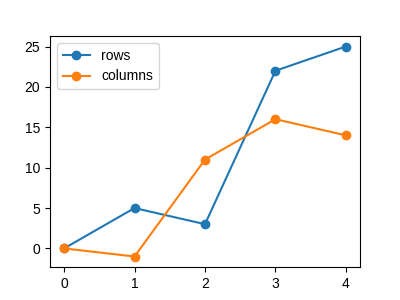

In [10]:
plt.figure(figsize=(4,3))
plt.plot(shifts[:,0], marker='o', label='rows') 
plt.plot(shifts[:,1], marker='o', label='columns') 
plt.legend()

To check that the shifts have been estimated correctly, one can either plot the shifted and unshifted data side by side:

interactive(children=(IntSlider(value=0, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

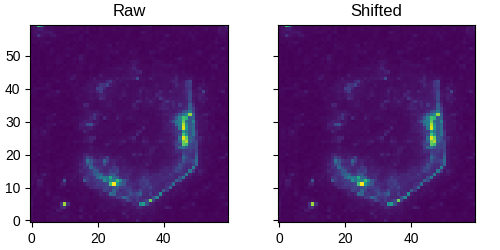

In [11]:
fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharex=True, sharey=True, constrained_layout=True)

im_raw   = ax[0].imshow(sxdm_raw[0], origin='lower')
im_shift = ax[1].imshow(sxdm_shift[0], origin='lower')

ax[0].set_title('Raw')
ax[1].set_title('Shifted')

@ipw.interact(i=(0, len(sxdm_raw)-1, 1))
def compare_raw_and_shifted(i=0):
    im_raw.set_data(sxdm_raw[i])
    im_shift.set_data(sxdm_shift[i])
    
    im_raw.set_clim(sxdm_raw[i].min(), sxdm_raw[i].max())
    im_shift.set_clim(im_raw.get_clim())
    
    fig.canvas.draw()

or make a gif and inspect it:

In [12]:
import gif

@gif.frame
def gifit(i):
    fig, ax = plt.subplots(1,1, layout='tight', figsize=(3,3))
    im = ax.imshow(sxdm_shift[i], norm=LogNorm())
    ax.set_title(f'{i}/{len(scan_nums)}')

frames = [gifit(s) for s in range(len(sxdm_raw))]
gif.save(frames, 'shift.gif', duration=1, unit='seconds', between='startend')

$\rightarrow$ [GIF](shift.gif)

Looking at the shifted plots, it is apparent that while for the first and last two images the shift seems correctly estimated, between the second and the third a sudden, incorrect jump is seenn. The problem is that the spatial distribution of the `mpx1x4_mpx4int` ROI sum changes abruptly in the middle of the rocking curve, a common scenarion when dealing with strained epitaxial layers. 

Below three different strategies to solve this problem are described.

## Interactive

A simple way to solve the problem is to use an interactive widget and manually mark identical points in successive images to estimate the shift. Using log scale this is straightforward:

In [13]:
viz = sxdm.widgets.bliss.GetShift(path_dset, scan_nums, counter_name='mpx1x4_mpx4int')
viz.iflog.value = True
viz.show()

Store the shifts in a variable like so:

In [14]:
shifts = viz.shifts

Shift the raw maps,

In [15]:
sxdm_shift = [ndi.shift(m, s, cval=np.nan) for m, s in zip(sxdm_raw, viz.shifts)]

And check:

interactive(children=(IntSlider(value=0, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

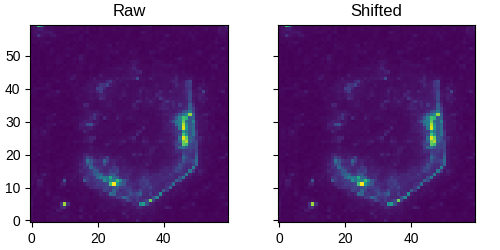

In [16]:
fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharex=True, sharey=True, constrained_layout=True)

im_raw   = ax[0].imshow(sxdm_raw[0], origin='lower')
im_shift = ax[1].imshow(sxdm_shift[0], origin='lower')

ax[0].set_title('Raw')
ax[1].set_title('Shifted')

@ipw.interact(i=(0, len(sxdm_raw)-1, 1))
def compare_raw_and_shifted(i=0):
    im_raw.set_data(sxdm_raw[i])
    im_shift.set_data(sxdm_shift[i])
    
    im_raw.set_clim(sxdm_raw[i].min(), sxdm_raw[i].max())
    im_shift.set_clim(im_raw.get_clim())
    
    fig.canvas.draw()

This method becomes tedious if the dataset consists of many scans. If the sample drift can be assumed to be linear, as is the case when it stems from the sample not sitting at the diffractometer's centre of rotation, one can simply discard the scan where the intensity changes abruptly and use the rest to estimate the shift; then, the missing shift point is found by interpolation. This is shown below.

## Linear interpolation

Start by defining the index of the image whose relative shift, because of its contrast being so different from the rest, is not computed correctly by `get_shift`. Call this index `bad_idx`:

In [17]:
bad_idx = 2

The corresponding scan is removed from the list defined above:

In [18]:
scan_nums_red = scan_nums[:]
scan_nums_red.remove(scan_nums[bad_idx])

To avoid less dramatic, but still present, abrupt intensity changes, only the top portion of the maps is selected for the shift estimation. Inspection of the data should convince one that this region is the most reliable. The selection is made by constructing a boolean mask `True` only in the top portion of the maps, and feeding it to the `reference_mask` parameter:

In [19]:
# mask is True for data that is considered in shift estimation
mask = np.zeros(sxdm.io.bliss.get_scan_shape(path_dset, '1.1'))
mask[35:, :] = 1

# load raw maps
sxdm_raw = [sxdm.io.bliss.get_counter_sxdm(path_dset, s, 'mpx1x4_mpx4int') for s in scan_nums_red]

# estimate shift bewtween successive images
shifts = sxdm.utils.get_shift(
    sxdm_raw,
    med_filt=(3,3),
    reference_mask=mask, # if mask used, upsample_factor is ignored
    upsample_factor=5
)

# shift raw maps
sxdm_shift = [ndi.shift(m, s, cval=np.nan) for m, s in zip(sxdm_raw, shifts)]

  0%|          | 0/3 [00:00<?, ?it/s]

Now check:

interactive(children=(IntSlider(value=0, description='i', max=3), Output()), _dom_classes=('widget-interact',)…

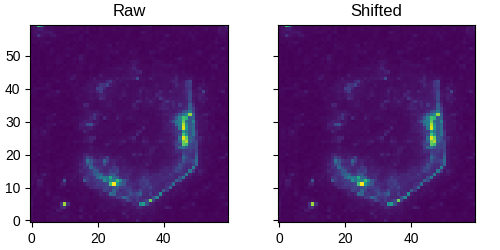

In [20]:
fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharex=True, sharey=True, constrained_layout=True)

im_raw   = ax[0].imshow(sxdm_raw[0], origin='lower')
im_shift = ax[1].imshow(sxdm_shift[0], origin='lower')

ax[0].set_title('Raw')
ax[1].set_title('Shifted')

@ipw.interact(i=(0, len(sxdm_raw)-1, 1))
def compare_raw_and_shifted(i=0):
    im_raw.set_data(sxdm_raw[i])
    im_shift.set_data(sxdm_shift[i])
    
    im_raw.set_clim(sxdm_raw[i].min(), sxdm_raw[i].max())
    im_shift.set_clim(im_raw.get_clim())
    
    fig.canvas.draw()

This looks convincing. Finally, the (partial) shifts are fitted with a straight line and the "missing shift" is found by interpolating at the `bad_idx`:

Text(6, -6, 'missing row shift')

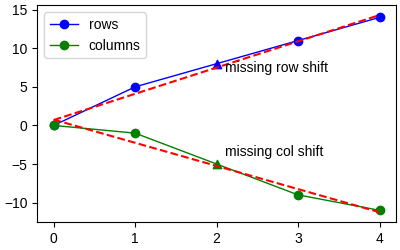

In [21]:
scan_idxs = np.arange(len(scan_nums))
scan_idxs_red = np.delete(scan_idxs, bad_idx)

ft_rows, ft_cols = [np.polyfit(scan_idxs_red, sh, 1) for sh in shifts.T] # 1D polynomial fit
sh_rows, sh_cols = [scan_idxs*f[0] + f[1] for f in (ft_rows, ft_cols)] # functions from the fit

shm_row, shm_col = [np.interp(bad_idx, scan_idxs, sh) for sh in (sh_rows, sh_cols)] 
shm_row, shm_col = [np.round(sh) for sh in (shm_row, shm_col)] # missing shift point

# plot
fig, ax = plt.subplots(1,1,figsize=(4,2.5), layout='constrained')

ax.plot(scan_idxs_red, shifts[:,0], marker='o', c='b', lw=1, label='rows')
ax.plot(scan_idxs, sh_rows, c='r', ls='--')
ax.scatter(bad_idx, shm_row, c='b', marker='^')

ax.plot(scan_idxs_red, shifts[:,1], marker='o', c='g', lw=1, label='columns')
ax.plot(scan_idxs, sh_cols, c='r', ls='--')
ax.scatter(bad_idx, shm_col, c='g', marker='^')

ax.legend()
ax.annotate('missing col shift', (bad_idx, shm_col), xytext=(6,6),  textcoords='offset points')
ax.annotate('missing row shift', (bad_idx, shm_row), xytext=(6,-6), textcoords='offset points')

The "missing shifts" are plotted as triangles in the figure above. These are inserted into the `shift` array, which is then used to shift the raw SXDM maps.

In [22]:
shifts = np.insert(shifts, bad_idx, np.array([shm_row, shm_col]), axis=0)

sxdm_raw = [sxdm.io.bliss.get_roidata(path_dset, s, 'mpx1x4_mpx4int') for s in scan_nums]
sxdm_shift = [ndi.shift(m, s, cval=np.nan) for m, s in zip(sxdm_raw, shifts)]

Check one last time:

interactive(children=(IntSlider(value=0, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

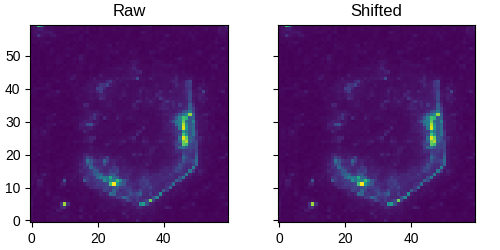

In [23]:
fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharex=True, sharey=True, constrained_layout=True)

im_raw   = ax[0].imshow(sxdm_raw[0], origin='lower')
im_shift = ax[1].imshow(sxdm_shift[0], origin='lower')

ax[0].set_title('Raw')
ax[1].set_title('Shifted')

@ipw.interact(i=(0, len(sxdm_raw)-1, 1))
def compare_raw_and_shifted(i=0):
    im_raw.set_data(sxdm_raw[i])
    im_shift.set_data(sxdm_shift[i])
    
    im_raw.set_clim(sxdm_raw[i].min(), sxdm_raw[i].max())
    im_shift.set_clim(im_raw.get_clim())
    
    fig.canvas.draw()

Sorted!

## Shift the raw data

Once the shift estimation is satisfactory, one proceeds to specify an **output directory** where processed data relative to this dataset will be stored. The function `make_xsocs_links` is then used to generate files that contain **links** to the raw data and an internal structure than can be read by the software [XSOCS](https://kmap.gitlab-pages.esrf.fr/xsocs/):

In [24]:
path_out = f'{path_exp}/{name_sample}_analysis'

In [25]:
sxdm.utils.bliss.make_xsocs_links(path_dset, path_out, scan_nums)

> Selecting scans 1.1 --> 5.1 in sample_0001
> Selecting detector mpx1x4
> Linking # 5.1/5.1 
> Done!



Having a XSOCS-compatible representation of the raw data, one can now proceed to correct the raw data for drifts using the calculated `shifts`. This is done with the function `shift_xsocs_data`.

<div class="alert alert-block alert-danger">
<b>Warning:</b> while this takes less than 2 minutes on a 40-cores machine, for realistic data one should expect something like 45 mins - 516^2 * number_of_angles shift operations are being performed!
</div>

In [26]:
path_master = f"{path_out}/{name_sample}_{name_dset}_master.h5"

In [27]:
%%time

sxdm.process.xsocs.shift_xsocs_data(
    path_master, path_out, shifts, overwrite=True, 
)

Using subh5_list=None, shifting file pattern ./data/MA1234/id01/20230710/sample_analysis/sample_0001*.1.h5 !


>> Shifting #4.1... chunk size (3, 172, 172)
>> Shifting #5.1... chunk size (3, 172, 172)

>> Shifting #3.1... chunk size (3, 172, 172)

>> Shifting #1.1... chunk size (3, 172, 172)


>> Shifting #2.1... chunk size (3, 172, 172)

sample_0001_1.1.h5 finished after 0.19m. I/O time: 0.19m

sample_0001_5.1.h5 finished after 1.41m. I/O time: 0.18m

sample_0001_4.1.h5 finished after 1.45m. I/O time: 0.18m

sample_0001_3.1.h5 finished after 1.61m. I/O time: 0.20m

sample_0001_2.1.h5 finished after 1.65m. I/O time: 0.19m
CPU times: user 79.7 ms, sys: 252 ms, total: 332 ms
Wall time: 1min 39s


Once the shifting is done, the path to the so-called XSOCS (shifted) "master file" are defined. This file contains links to the actual (shifted) data, which in contrast to the raw data, is physically stored in `path_out`.

In [28]:
ls -lht {path_out}

total 179M
-rw-r--r-- 1 zatterin id01 1.2K Feb  5 18:51 sample_0001_master_shifted.h5
-rw-r--r-- 1 zatterin id01  25M Feb  5 18:51 sample_0001_2.1_shifted.h5
-rw-r--r-- 1 zatterin id01  49M Feb  5 18:51 sample_0001_3.1_shifted.h5
-rw-r--r-- 1 zatterin id01  20M Feb  5 18:51 sample_0001_4.1_shifted.h5
-rw-r--r-- 1 zatterin id01  15M Feb  5 18:51 sample_0001_5.1_shifted.h5
-rw-r--r-- 1 zatterin id01  17M Feb  5 18:50 sample_0001_1.1_shifted.h5
-rw-r--r-- 1 zatterin id01 1.1K Feb  5 18:50 sample_0001_master.h5
-rw-r--r-- 1 zatterin id01 151K Feb  5 18:50 sample_0001_5.1.h5
-rw-r--r-- 1 zatterin id01 151K Feb  5 18:50 sample_0001_4.1.h5
-rw-r--r-- 1 zatterin id01 151K Feb  5 18:50 sample_0001_3.1.h5
-rw-r--r-- 1 zatterin id01 151K Feb  5 18:50 sample_0001_2.1.h5
-rw-r--r-- 1 zatterin id01 151K Feb  5 18:50 sample_0001_1.1.h5
-rw-r--r-- 1 zatterin id01  51M Nov 13 19:03 qspace_shift_0.h5
-rw-r--r-- 1 zatterin id01 2.1M Nov 13 19:02 0001_framesum.npy


In [29]:
path_master_shifted = f"{path_out}/{name_sample}_{name_dset}_master_shifted.h5"

Check that the shifting has been done correctly by opening the data of one of the shifted datasets:

0it [00:00, ?it/s]

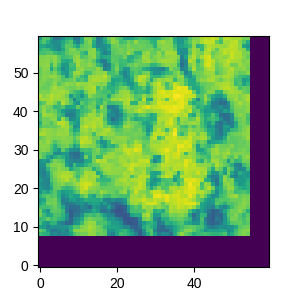

In [33]:
scan_no = "3.1"

sh = sxdm.io.bliss.get_scan_shape(path_dset, scan_no)
_shift_data = sxdm.io.bliss.get_sxdm_pos_sum(path_master_shifted, scan_no, detector="detector")
_shift_data = _shift_data.reshape(sh)

plt.figure(figsize=(3, 3))
plt.imshow(_shift_data)

Indeed the data has been shifted! One can proceed to transform such data from angular to (orthonormal) reciprocal space.

# Transformation from angular to reciprocal space

Expressing data in orthonormal reciprocal space is based on the angular values read from the diffractometer's motors. Discrepancies between the "real" and experimental value of these angles may exists due to alignment imprecisions, or due to measurement of the Bragg signal in a portion of the detector that *does not* correspond to the "central pixel", i.e. the pixel hit by the maximum of the direct X-ray beam when all diffractometer angles are zero.

To estimate such angular offsets, first the sum all of the detector frames collected as part of a SXDM map at a given angle is taken; scan `3.1` is chosen, as this represents the middle of the rocking curve and should correspond to a slice in reciprocal space of the most intense portion of the probed Bragg peak: 

In [34]:
scan_no = '3.1'

In [35]:
fint = sxdm.io.bliss.get_sxdm_frame_sum(path_dset, scan_no)

0it [00:00, ?it/s]

The array `fint` has the shape of the detector active area, i.e.

In [36]:
fint.shape

(516, 516)

The function `get_qspace_vals` is then used to obtain the $(q_x,q_y, q_z)$ coordinate of each pixel in the frame sum `fint`, i.e. a $\vec{q}$ is associated with each pixel:

Now,
* Load some angles
* Specify angular offsets (start with 0)
* Calculate q-space coordinates 
* Compute the COM of the 104 GaN peak from the cif file
* Compute the COM for the measured scan
* Compare the two and determine the offets
* Modify offsets accordingly

In [37]:
# load material, choose from library or use a cif file
mat = xu.materials.GaN
# mat = xu.materials.Crystal.fromCIF("./data/GaN.cif")

# specify diffractometer rotations and crystal directions
qconv = xu.QConversion(("y-", "z-"), ("y-"), (1, 0, 0))  # eta, phi, del
hxrd = xu.FourC(mat.Q(-1, 2, 0), mat.Q(0, 0, 1), en=9000, qconv=qconv)

# compute COM from cif data
com_th = hxrd.Transform(mat.Q(0, 2, 5))

# compute diffractometer angles from q-space coords.
bounds = ((0, 110), (-110, 110), (0, 130))
ang, qerror, errcode = xu.Q2AngFit(com_th, hxrd, bounds)
eta_th, phi_th, delta_th = ang

# load angles
nu, phi, eta, delta = [
    sxdm.io.bliss.get_positioner(path_dset, scan_no, x)
    for x in ["nu", "phi", "eta", "delta"]
]

# specify offsets
offsets = {
    "phi": phi - phi_th,
    "eta": eta - eta_th,
    "delta": delta - delta_th,
}

# compute q-space coordinates - shape is (516,516)
qx, qy, qz = id01lib.xrd.qspace.bliss.get_qspace_vals(
    path_dset,
    scan_no,
    offsets=offsets,
    ignore_mpx_motors=True,
)


# compute COM for experimental data
_roi = np.s_[:, :]
com_exp = [
    x
    for x in sxdm.process.math.calc_com_3d(
        fint[_roi], qx[_roi], qy[_roi], qz[_roi], n_pix=None
    )
]

# print COMs
print("\nTheo: ", [float(f"{x:.4f}") for x in com_th])
print("Exp : ", [float(f"{x:.3f}") for x in com_exp])
print("\ndiff: ", [float(f"{x:.4f}") for x in com_exp - com_th])

Using cen_pix: row/y=256.169, col/x=138.845
Using det_dist = 0.94004 m
Using energy = 8.99971 keV
NOT correcting the central pixel for mpxy=-14.0, mpxz=0.0
------------------
Subtracting 0.254 from eta
Subtracting -6.135 from phi
Subtracting 0.538 from delta

Theo:  [3.9405, -2.2751, 6.0578]
Exp :  [3.934, -2.288, 6.054]

diff:  [-0.0061, -0.0127, -0.0036]


These have the same shape as `fint`,

In [38]:
print(*[q.shape for q in (qx, qy, qz)])

(516, 516) (516, 516) (516, 516)


The dictionary `offsets` has been initialised to hold the (key, value) pairs `angle:0` for each angle only to demonstrate its use. When offsets are zero as in this case, it is sufficient to pass `offsets=None` to `get_qspace_vals`.

One should then check that the q-space coordinates computed from the diffractometer angles correspond to the expectations, i.e. that the Bragg peak is located at $(q_x,q_y, q_z)$ coordinates consistent with the crystallography of the sample. This may not always be the case straight away, as the default position of the q-space axes is determined relative to the incident beam direction and that of the axes of rotation of the diffractometer. Thus, unless the main crystallographic axes of the sample were aligned with such directions, the q-space coordinates computed will not be those of the reciprocal lattice of the sample. One must therefore either change the definition of $q_x$ (`ipdir`) and $q_z$ (`ndir`) in `get_qspace_vals`, or add angular offsets via `offsets` to artificially rotate the crystal so that its main crystallographic directions match the orthonrmal q-space axes.

Such check is done by plotting the projections of `fint`:

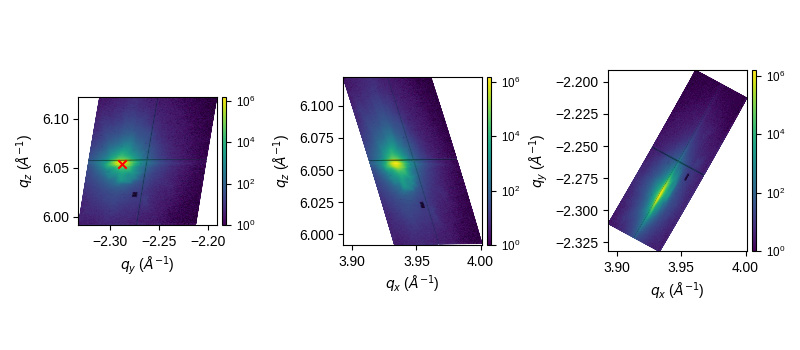

In [39]:
fig, ax = plt.subplots(1,3,figsize=(8,3.5), dpi=100)

ax[0].pcolormesh(qy, qz, fint, norm=LogNorm(), shading='gouraud')
ax[1].pcolormesh(qx, qz, fint, norm=LogNorm(), shading='gouraud')
ax[2].pcolormesh(qx, qy, fint, norm=LogNorm(), shading='gouraud')

[ax[i].set_ylabel(r'$q_z$ ($\AA^{-1}$)') for i in (0,1)]
[ax[i].set_xlabel(r'$q_x$ ($\AA^{-1}$)') for i in (1,2)]

ax[0].set_xlabel(r'$q_y$ ($\AA^{-1}$)')
ax[2].set_ylabel(r'$q_y$ ($\AA^{-1}$)')

ax[0].scatter(com_exp[1], com_exp[2], marker='x', c='r')

for a in ax:
    a.set_aspect('equal')
    sxdm.plot.add_colorbar(a, a.get_children()[0])
    
fig.tight_layout()

A clearer visualisation is perhaps obtained by plotting the `fint` slice in 3D:

Text(0.5, 0, '$q_z~(\\AA^{-1})$')

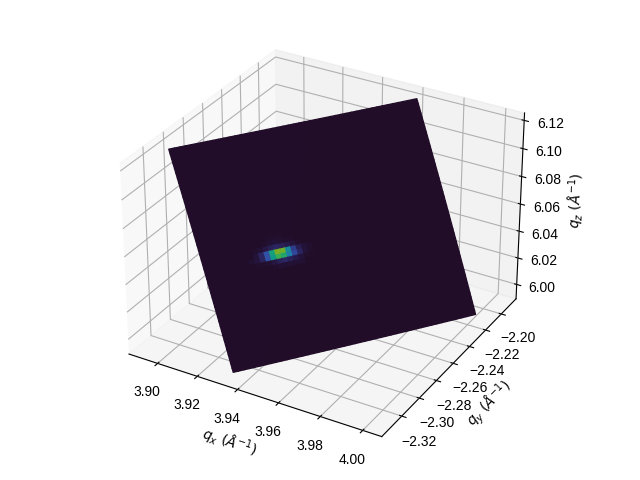

In [40]:
color_map = plt.get_cmap('turbo')
ffint = fint.astype(np.float64)
ffint /= ffint.max()
I = color_map(ffint)

fig = plt.figure(layout='tight')
ax = fig.add_subplot(projection='3d')

ax.plot_surface(qx, qy, qz, facecolors=I)

ax.set_xlabel(r'$q_x~(\AA^{-1})$')
ax.set_ylabel(r'$q_y~(\AA^{-1})$')
ax.set_zlabel(r'$q_z~(\AA^{-1})$')

Mask bad pixels:

In [41]:
%%time

from tqdm.notebook import tqdm

path_framesum = f"{path_out}/{name_dset}_framesum.npy"

if not os.path.isfile(path_framesum):
    fint_tot = np.zeros_like(fint)
    for scan_no in tqdm(scan_nums):
        fint_tot += sxdm.io.bliss.get_sxdm_frame_sum(
            path_dset, scan_no, pbar=False, detector="mpx1x4"
        )
    np.save(path_framesum, fint_tot)
else:
    print(f"Loading: \n\t{path_framesum}\n")
    fint_tot = np.load(path_framesum)

Loading: 
	./data/MA1234/id01/20230710/sample_analysis/0001_framesum.npy

CPU times: user 0 ns, sys: 3.69 ms, total: 3.69 ms
Wall time: 15.1 ms


Text(0.5, 1.0, 'Masked')

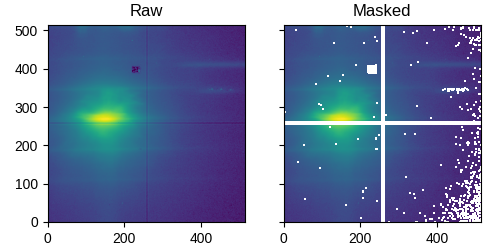

In [42]:
%matplotlib widget

# mask
_roi = np.s_[:, :]
fmask = np.zeros_like(fint_tot)
fmask[_roi][fint_tot[_roi] == 0] = 1

# plot
fig, ax = plt.subplots(
    1, 2, sharey=True, sharex=True, layout="constrained", figsize=(5, 2.5), 
)

ax[0].imshow(fint_tot, norm=LogNorm())
ax[1].imshow(np.ma.masked_array(fint_tot, mask=fmask), norm=LogNorm())

ax[0].set_title("Raw")
ax[1].set_title("Masked")

Once angular offsets have been established, one should proceed to estimate the largest number of bins that can be used to grid the data in q-space. Interpolating intensity on an orthonormal grid is necessary when expressing it in reciprocal space as the data itself, acquired in angular space, is not orthonormal.

In [43]:
maxbins = sxdm.process.xsocs.estimate_n_bins(path_master, offsets=offsets)
print(f'Max n of bins: {maxbins}')

Using cen_pix: row/y=256.169, col/x=138.845
Using det_dist = 0.94004 m
Using energy = 9.00001 keV
Subtracting 0.254 from eta
Subtracting -6.135 from phi
Subtracting 0.538 from delta


Max n of bins: [9, 15, 11]


Based on the output of the above cell and in order to use an isotropic grid size, the number of bins is set to $10^3$ in the function `grid_qspace_xsocs` called below. This function requires an output file as an input, specified below as `qspace_shift_0.h5`, as well as the master XSOCS (shifted) file, `path_master_shifted`.

<div class="alert alert-block alert-danger">
<b>Warning:</b> once again, while the computation that follows is relatively quick for the small dataset being treated here, it will take longer for realistic data.
</div>

In [44]:
path_qspace = f'{path_out}/qspace_shift_0.h5'

In [45]:
%%time

try:
    sxdm.process.xsocs.grid_qspace_xsocs(
        path_qspace,
        path_master_shifted,
        (9, 15, 11),
        overwrite=True,
        offsets=offsets,
        mask=fmask
    )
except RuntimeError:
    print('> Data exists! Set overwrite=True if needed.\n')

Subtracting 0.254 from eta
Subtracting -6.135 from phi
Subtracting 0.538 from delta


Process 3 started.Process 1 started.Process 5 started.Process 2 started.Process 6 started.Process 0 started.Process 8 started.Process 11 started.Process 7 started.Process 13 started.Process 14 started.Process 4 started.Process 20 started.Process 12 started.
Process 16 started.Process 9 started.Process 10 started.Process 17 started.
Process 19 started.Process 24 started.

Process 15 started.Process 23 started.Process 28 started.



Process 26 started.Process 32 started.Process 33 started.
Process 25 started.Process 30 started.
Process 27 started.
Process 35 started.Process 29 started.

Process 34 started.
Process 36 started.
Process 37 started.



Process 38 started.Process 39 started.






Process 31 started.Process 18 started.











#0/3600
Process 21 started.
Process 22 started.
#100/3600
#200/3600
#300/3600
#400/3600
#500/3600
#600/3600
#700/3600
#800/3600
#900/3600
#1000/3600
#1100/3600
#120

Once the above cell is run, the file `qspace_shift_0.h5` will contain the sought 5D dataset; namely, $I(x, y, q_x, q_y, q_z)$.

# Determination of a VOI in reciprocal space

At this point, one has the `qspace_shift_0.h5` file, containing the sought 5D dataset; namely, $I(x, y, q_x, q_y, q_z)$.

Next, one wants to select a volume of interest (VOI) in order to fit a centre of mass or a Gaussian function to the intensity contained within it, as a function of position $(x,y)$.

First one loads the q-space $(q_x, q_y, q_z)$ coordinates `qspace` file:

In [46]:
qx, qy, qz = sxdm.utils.get_qspace_coords(path_qspace)

Then the *average* q-space intensity is computed by summing over all of the probed $(x, y)$ coordinates using the `get_qspace_avg` function:

In [47]:
qspace_avg = sxdm.io.xsocs.get_qspace_avg(path_qspace)

  0%|          | 0/40 [00:00<?, ?it/s]

The projections along $q_x$, $q_y$ and $q_z$ io this average reciprocal space volume are plotted below.

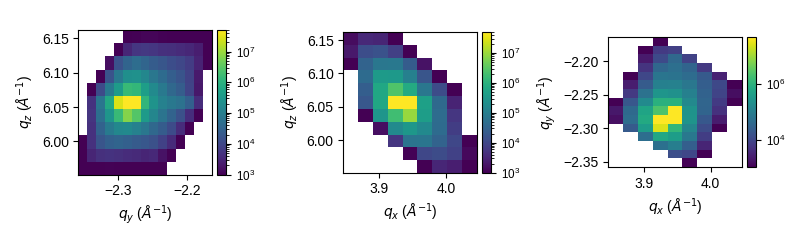

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2.5), layout='tight')

_qext = sxdm.utils.get_q_extents(qx, qy, qz)
for i in range(3):
    ax[i].imshow(qspace_avg.sum(i).T, extent=_qext[i],
                 origin='lower', aspect='equal', norm=LogNorm(1e3,5e7))
    cbar = sxdm.plot.add_colorbar(ax[i], ax[i].get_images()[0], size='7%')

# labels etc.
ax[0].set_xlabel(r'$q_y$ ($\AA^{-1}$)')
ax[2].set_ylabel(r'$q_y$ ($\AA^{-1}$)')

for i in (1, 2):
    ax[i].set_xlabel(r'$q_x$ ($\AA^{-1}$)')

for i in (0, 1):
    ax[i].set_ylabel(r'$q_z$ ($\AA^{-1}$)')

The next step is to identify an appropriate sub-volume of interest (VOI) within `qspace_avg`. This VOI corresponds to the region for which centres of mass (COMs) will be computed as a function of $(x, y)$. The widget below is used to determine the indexes of the `qspace_avg` array that slice the array so as to obtain a sought VOI:

IntSlider(value=5, description='depth', max=10)

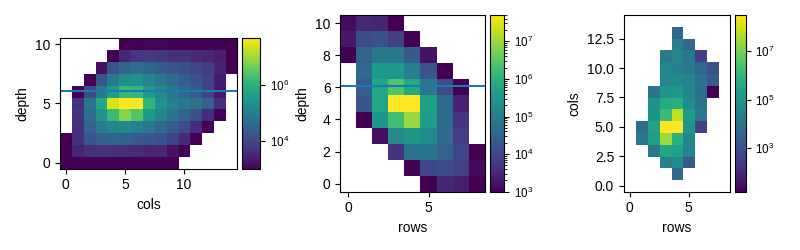

In [49]:
i0 = 5

fig, ax = plt.subplots(1, 3, figsize=(8, 2.5), layout='tight')

im0 = ax[0].imshow(qspace_avg.sum(0).T, norm=LogNorm(1e3,5e7))
lines0 = [ax[i].axhline(qz[i0]) for i in (0, 1)]
ax[0].set_xlabel(r'cols')
ax[0].set_ylabel(r'depth')

im1 = ax[1].imshow(qspace_avg.sum(1).T, norm=LogNorm(1e3,5e7))
ax[1].set_xlabel(r'rows')
ax[1].set_ylabel(r'depth')

imslice = ax[2].imshow(qspace_avg[..., i0].T, norm=LogNorm())
ax[2].set_xlabel(r'rows')
ax[2].set_ylabel(r'cols')

for a in ax:
    cbar = sxdm.plot.add_colorbar(a, a.get_images()[0], size='10%')

fig.subplots_adjust(bottom=.22, top=.9, left=.08, right=.98)
    
def sliceit(change):
    i0 = change['new']
    _0 = [l.set_ydata(i0) for l in lines0]
    imslice.set_data(qspace_avg[..., i0].T)

    ax[2].set_title(f'depth: {i0}')
    fig.canvas.draw()

slider = ipw.IntSlider(value=i0, min=0, max=qspace_avg.shape[-1]-1, description='depth')
slider.observe(sliceit, names='value')
slider

The identified `rows, cols, depth` indexes are used to define a boolean mask where `False` values correspond to the VOI (i.e. everything but the VOI is masked),

In [50]:
mask = np.ones(qspace_avg.shape).astype('bool')
mask[2:7,  2:10, 2:8] = False # rows, cols, depth

# cxp, cyp, czp = [
#     int(x)
#     for x in sxdm.process.math.calc_com_3d(qspace_avg, *np.indices(qspace_avg.shape))
# ]

# mask = np.zeros(qspace_avg.shape).astype("bool")
# mask[cxp - 5 : cxp + 5, cyp - 25 : cyp + 25, czp - 30 : czp + 30] = True
# mask = ~mask

as well as other quantities related to it that will be useful through the rest of the analysis:

In [51]:
roi         = np.where(np.invert(mask)) # list of VOI indexes
roi_idxs    = [(x.min(), x.max()+1) for x in roi] # VOI in pixel coords
roi_slice   = tuple([slice(x.min(), x.max()+1) for x in roi]) # VOI as slices to preserve VOI shape
roi_qcoords = [q[roi_slice] for q in np.meshgrid(qx, qy, qz, indexing='ij')] # VOI in q-coordinates

qspace_avg_masked = np.ma.masked_array(data=qspace_avg, mask=mask) # VOI via a masked array: original shape
qspace_avg_sliced = qspace_avg[roi_slice] # VOI via slicing: new shape

The VOI can be neatly visualised in 3D using `ipyvolume`:

In [52]:
import ipyvolume as ipv

roi_surf = []
for i, j, k in ([0,1,2], [0,2,1]):
    for m in (0,1):
        a, b = np.meshgrid(roi_idxs[i], roi_idxs[j])
        c = np.ones((2,2)) * roi_idxs[k][m]
        roi_surf.append(np.array([a,b,c])[[0,j,k]])

fig = ipv.figure()
iso = ipv.plot_isosurface(qspace_avg, level=1e5)

for r in roi_surf:
    ipv.plot_wireframe(*r, color='green')
    
ipv.xlim(0,qspace_avg.shape[0])
ipv.ylim(0,qspace_avg.shape[1])
ipv.zlim(0,qspace_avg.shape[2])

ipv.view(40, 90)
ipv.show()

ModuleNotFoundError: No module named 'ipyvolume'

Alteratively, the VOI is overlaid on the orthogonal projections of `qspace_avg`:

In [ ]:
%matplotlib widget

from matplotlib.patches import Rectangle as R

fig, ax = plt.subplots(1, 3, figsize=(8, 2.5), layout='tight')

# draw the _roi as rectangles
_roi = [y for x in roi_qcoords for y in [x.min(), x.max()]]
r2 = R((_roi[0], _roi[2]), _roi[1]-_roi[0], _roi[3]-_roi[2],
       edgecolor='r', facecolor='none', transform=ax[2].transData)  # xy
r1 = R((_roi[0], _roi[4]), _roi[1]-_roi[0], _roi[5]-_roi[4],
       edgecolor='r', facecolor='none', transform=ax[1].transData)  # xz
r0 = R((_roi[2], _roi[4]), _roi[3]-_roi[2], _roi[5]-_roi[4],
       edgecolor='r', facecolor='none', transform=ax[0].transData)  # yz

_qext = sxdm.utils.get_q_extents(qx, qy, qz)
for i, r in zip(range(3), [r0, r1, r2]):
    ax[i].imshow(qspace_avg_masked.sum(i).T, extent=_qext[i],
                 origin='lower', aspect='equal', norm=LogNorm(1e4,1e8))
    ax[i].add_patch(r)
    cbar = sxdm.plot.add_colorbar(ax[i], ax[i].get_images()[0], size='7%')

# labels etc.
ax[0].set_xlabel(r'$Q_y$ [$\AA^{-1}$]')
ax[2].set_ylabel(r'$Q_y$ [$\AA^{-1}$]')

for i in (1, 2):
    ax[i].set_xlabel(r'$Q_x$ [$\AA^{-1}$]')

for i in (0, 1):
    ax[i].set_ylabel(r'$Q_z$ [$\AA^{-1}$]')

# Calculation and visualisation of local structural parameters

## COMs

if the VOI selection performed in the previous section is satisfactory, one can proceed to compute the COMs of the intensity falling within the VOI as a function of $(x, y)$. This is done with `calc_coms_qspace3d`, which requires as an input the VOI expressed as a mask (`mask`), and allows one to limit the COM calculation to the N most intense pixels within the VOI via the argument `n_pix=N`. Here only 10 pixels are used:

In [ ]:
cx_flat, cy_flat, cz_flat = sxdm.process.math.calc_coms_qspace3d(path_qspace, mask, n_pix=10)

Note how for compatibility with XSOCS, COMs are returned as a flat $x*y$ array, i.e.

In [ ]:
print(cx_flat.shape)

Next the intensity falling within the VOI is computed:

In [ ]:
roi_int_flat = sxdm.process.math.calc_roi_sum(path_qspace, mask)

The latter is also flattened. The cell below reshapes the `cx, cy, cz, roi_int` arays to $(x, y)$ and masks the portion of each array which have been shifted beforehand:

In [ ]:
# load piezo coordinates
pix, piy = sxdm.io.xsocs.get_piezo_motorpos(path_master_shifted)

# (x, y) shift window and extents
r0, r1 = int(np.round(shifts[:, 0].max())), int(np.round(shifts[:, 0].min()))
c0, c1 = int(np.round(shifts[:, 1].max())), int(np.round(shifts[:, 1].min()))

pi_win = np.s_[r0:r1 if r1 != 0 else None, c0:c1 if c1 != 0 else None]
pi_ext = [pix.min(), pix.max(), piy.min(), piy.max()]

# mask based on (x, y) shift window
dmask = np.ones_like(pix)
dmask[pi_win] = 0

# make masked arrays
cx, cy, cz, roi_int = [
    np.ma.masked_where(dmask != 0, x.reshape(pix.shape))
    for x in (cx_flat, cy_flat, cz_flat, roi_int_flat)
]

Finally, the values of `cx, cy, cz` are used to compute $\vec{q}(x, y)$. The values of $\vec{q}$ depend on the **origin** with respect to which these are computed. Furthermore, local tilts are only meaningful if defined relative to a reference axis. Thus, $\vec{q}$ is best computed relative to a reference $\vec{q}_\mathsf{ref}$. The choice of $\vec{q}_\mathsf{ref}$ is arbitrary. Here the average COM within the VOI is taken as $\vec{q}_\mathsf{ref}$, in order to visualise the deviations of $\vec{q}(x, y)$ from its *average*:

In [ ]:
# q_local 2D vector field and magnitude
Q = np.array([cx, cy, cz]).reshape(3, np.prod(cx.shape))
q = np.sqrt(cx ** 2 + cy ** 2 + cz ** 2)

# q_0 components
cx0, cy0, cz0 = cx.mean(), cy.mean(), cz.mean()

# q_0 vector and magnitude
Q_av = np.array([cx0, cy0, cz0])
q_av = np.sqrt(cx0 ** 2 + cy0 ** 2 + cz0 ** 2)

# relative inclination and azimuth between the q_local and q_0
inc_rel = np.degrees(np.arccos(np.dot(Q_av, Q).reshape(q.shape) / (q * q_av)))
azi_rel = np.degrees(np.arctan2(cx - cx0, cy - cy0))

In [ ]:
d = 2 * np.pi / q
strain = (q - q.mean()) / q.mean()
tilt = sxdm.plot.make_hsv(inc_rel, 180 + azi_rel)

Finally, the computed quantities are plotted (explanation below):

<div class="alert alert-block alert-warning">
    <b>Note:</b> if <code>ipython</code> starts complaining that you have too many figures open, reset the figures with <code>%matplotlib widget</code>.
</div>

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(10,6), layout='constrained', dpi=95)
subfigs = fig.subfigures(1, 2, wspace=None, width_ratios=[3, 1])

### Local parameters ###

# figure init
titles = [
    r"Intensity (a.u.)",
    r"$d_{02.5}~(\AA)$",
    r"$\vec{q}_{02.5}$ relative tilt",
    r"$\vec{q}_{02.5}$ distibution",
]

ax = subfigs[0].subplots(2,2).flatten()

# plots
roi_int_plot, d_plot, tilt_plot = [x[pi_win] for x in (roi_int, d, tilt)]
pi_ext = [pix[pi_win].min(), pix[pi_win].max(), piy[pi_win].min(), piy[pi_win].max()]

ax[0].imshow(roi_int_plot, extent=pi_ext, cmap="viridis")
ax[1].imshow(d_plot, extent=pi_ext, cmap="viridis")
ax[2].imshow(tilt_plot, extent=pi_ext, cmap="hsv")

_az = np.degrees(np.arctan2(cy - cy0, cx - cx0))

qxr, qyr, qzr = roi_qcoords
qext = [qxr.min(), qxr.max(), qyr.min(), qyr.max()]

ax[3].imshow(
    qspace_avg_sliced.sum(2).T,
    extent=qext,
    norm=LogNorm(5e4, 1e7),
    cmap="magma",
    origin="lower",
)
ax[3].scatter(
    cx, cy, marker="o", s=0.5, c=_az, cmap="hsv", alpha=0.5, vmin=-180, vmax=180
)

# normal colorbars
for a, t in zip(ax, titles):
    a.set_title(t, pad=20)
    if a != ax[2]:
        cbar = sxdm.plot.add_colorbar(a, a.get_images()[0])
        try:
            cbar.ax.ticklabel_format(scilimits=(0, 0), useMathText=True)
        except:
            pass

# tilt colorbar
labels = [
    "$[\overline{1}2\overline{1}0]$",
    "$[\overline{1}010]$",
    "$[1\overline{2}10]$",
    "$[10\overline{1}0]$",
]
labels.append(labels[0])
sxdm.plot.add_hsv_colorbar(inc_rel, ax[2], labels)

# labels
_ = [a.set_xlabel("x $(\mathsf{\mu m})$") for a in ax[:3]]
_ = [a.set_ylabel("y $(\mathsf{\mu m})$") for a in ax[:3]]

ax[3].set_ylabel(r"$q_y$ ($\AA^{-1}$)")
ax[3].set_xlabel(r"$q_x$ ($\AA^{-1}$)")

# more labels
_ = sxdm.plot.add_directions(
    ax[2], r"$[\overline{1}2\overline{1}0]$", r"$[\overline{1}010]$", "lower left", angle=offsets['phi']
)

### Projections and VOI ###

ax = subfigs[1].subplots(3,1)

# draw the _roi as rectangles
_roi = [y for x in roi_qcoords for y in [x.min(), x.max()]]
r2 = R((_roi[0], _roi[2]), _roi[1]-_roi[0], _roi[3]-_roi[2],
       edgecolor='r', facecolor='none', transform=ax[2].transData)  # xy
r1 = R((_roi[0], _roi[4]), _roi[1]-_roi[0], _roi[5]-_roi[4],
       edgecolor='r', facecolor='none', transform=ax[1].transData)  # xz
r0 = R((_roi[2], _roi[4]), _roi[3]-_roi[2], _roi[5]-_roi[4],
       edgecolor='r', facecolor='none', transform=ax[0].transData)  # yz

_qext = sxdm.utils.get_q_extents(qx, qy, qz)
for i, r in zip(range(3), [r0, r1, r2]):
    ax[i].imshow(qspace_avg.sum(i).T, extent=_qext[i],
                 origin='lower', aspect='equal', norm=LogNorm(1e5,5e6))
    ax[i].add_patch(r)
    cbar = sxdm.plot.add_colorbar(ax[i], ax[i].get_images()[0], size='7%')

# labels etc.
ax[0].set_xlabel(r'$q_y~(\AA^{-1})$')
ax[2].set_ylabel(r'$q_y~(\AA^{-1})$')

for i in (1, 2):
    ax[i].set_xlabel(r'$q_x~(\AA^{-1})$')

for i in (0, 1):
    ax[i].set_ylabel(r'$q_z~(\AA^{-1})$')

In [ ]:
%matplotlib widget

fig = plt.figure(figsize=(10, 6), layout="constrained", dpi=95)
subfigs = fig.subfigures(1, 2, wspace=None, width_ratios=[3, 1])

######

# rotate the result arrays to match the q-space directions
roi_int_plot, d_plot, tilt_plot = [
    np.flipud(np.rot90(m, k=1)) for m in (roi_int, d, tilt)
]

# figure init
titles = [
    r"Intensity (a.u.)",
    r"$d_{02.5}~(\AA)$",
    r"$\vec{q}_{02.5}$ relative tilt",
    r"$\vec{q}_{02.5}$ distibution",
]

ax = subfigs[0].subplots(2, 2).flatten()

# plots
ax[0].imshow(roi_int_plot, extent=pi_ext, cmap="viridis")
ax[1].imshow(d_plot, extent=pi_ext, cmap="viridis")
ax[2].imshow(tilt_plot, extent=pi_ext, cmap="hsv")

_az = np.degrees(np.arctan2(cy - cym, cx - cxm))

qxr, qyr, qzr = roi_qcoords
qext = [qxr.min(), qxr.max(), qyr.min(), qyr.max()]

ax[3].imshow(
    qspace_avg_sliced.sum(2).T,
    extent=qext,
    norm=LogNorm(5e4, 1e7),
    cmap="magma",
    origin="lower",
)
ax[3].scatter(
    cx, cy, marker="o", s=0.5, c=-_az, cmap="hsv", alpha=0.5, vmin=-180, vmax=180
)

# normal colorbars
for a, t in zip(ax, titles):
    a.set_title(t, pad=20)
    if a != ax[2]:
        cbar = sxdm.plot.add_colorbar(a, a.get_images()[0])
        try:
            cbar.ax.ticklabel_format(scilimits=(0, 0), useMathText=True)
        except:
            pass

# tilt colorbar
labels = [
    "$[\overline{1}2\overline{1}0]$",
    "$[\overline{1}010]$",
    "$[1\overline{2}10]$",
    "$[10\overline{1}0]$",
]
labels.append(labels[0])
sxdm.plot.add_hsv_colorbar(tiltmag, ax[2], labels)

# labels
_ = [a.set_xlabel("x $(\mathsf{\mu m})$") for a in ax[:3]]
_ = [a.set_ylabel("y $(\mathsf{\mu m})$") for a in ax[:3]]

ax[3].set_ylabel(r"$q_y$ ($\AA^{-1}$)")
ax[3].set_xlabel(r"$q_x$ ($\AA^{-1}$)")

# more labels
_ = sxdm.plot.add_directions(
    ax[2], r"$[\overline{1}2\overline{1}0]$", r"$[\overline{1}010]$", "lower left", angle=offsets['phi']
)

###########

ax = subfigs[1].subplots(3, 1)

# draw the _roi as rectangles
_roi = [y for x in roi_qcoords for y in [x.min(), x.max()]]
r2 = R(
    (_roi[0], _roi[2]),
    _roi[1] - _roi[0],
    _roi[3] - _roi[2],
    edgecolor="r",
    facecolor="none",
    transform=ax[2].transData,
)  # xy
r1 = R(
    (_roi[0], _roi[4]),
    _roi[1] - _roi[0],
    _roi[5] - _roi[4],
    edgecolor="r",
    facecolor="none",
    transform=ax[1].transData,
)  # xz
r0 = R(
    (_roi[2], _roi[4]),
    _roi[3] - _roi[2],
    _roi[5] - _roi[4],
    edgecolor="r",
    facecolor="none",
    transform=ax[0].transData,
)  # yz

_qext = sxdm.utils.get_q_extents(qx, qy, qz)
for i, r in zip(range(3), [r0, r1, r2]):
    ax[i].imshow(
        qspace_avg.sum(i).T,
        extent=_qext[i],
        origin="lower",
        aspect="equal",
        norm=LogNorm(1e4, 1e8),
    )
    ax[i].add_patch(r)
    cbar = sxdm.plot.add_colorbar(ax[i], ax[i].get_images()[0], size="7%")

# labels etc.
ax[0].set_xlabel(r"$q_y~(\AA^{-1})$")
ax[2].set_ylabel(r"$q_y~(\AA^{-1})$")

for i in (1, 2):
    ax[i].set_xlabel(r"$q_x~(\AA^{-1})$")

for i in (0, 1):
    ax[i].set_ylabel(r"$q_z~(\AA^{-1})$")

The figure above displays, as a function of $(x,y)$ and in clockwise order:

1. The intensity in the VOI;
2. The interplanar distance 
3. The tilt magitude (hue) and direction (color)
4. The distribution of `cx, cy` in the $(q_x, q_y)$ plane, overlaid on the $q_z$ projection of `qspace_avg`.

Note how 3) depends on the specific choice of `cxm, cym, czm`, i.e. of the reference $\vec{q}_\mathsf{ref}$ . These data can be further explored using the widget below. Click around and see the diffraction pattern evolve! The arrow keys can also be used. Have a look at the docstring of `Inspect5DQspace` to see what else it can do.

In [ ]:
%matplotlib widget

results = {'interplanar_distance': d, 'roi_intensity': roi_int,
           'tilt': tilt, 'tilt_magnitude': tiltmag, 'tilt_azimuth': az}

viz = sxdm.widgets.xsocs.Inspect5DQspace(
    results,
    path_qspace,
    relim_int=True,
    init_idx=[20, 20],
    projections='2d',
    coms=[cx,cy,cz]
)

viz.ax[0, 0].get_images()[0].set_cmap("viridis")
viz.fig.set_figwidth(10)
viz.fig.set_figheight(8)
viz._iflog.value = True
viz.show()

## Gaussian fitting (with XSOCS)

In [ ]:
from xsocs.process.fit import PeakFitter, FitTypes, BackgroundTypes
from xsocs.io.FitH5 import FitH5

fitter = PeakFitter(
    path_qspace,
    fit_type=FitTypes.GAUSSIAN,
    n_proc=os.cpu_count(),
    roi_indices=roi_idxs,
    background=BackgroundTypes.SNIP,
)

In [ ]:
%%time 
    
# Run the processing and get the results
results = fitter.peak_fit()

# Check for errors
if fitter.status != fitter.DONE:
    print("Fit process failed")
    sys.exit()

headers = ['sample_x', 'sample_y']
values = [results.sample_x, results.sample_y]

for dimension, axis_name in enumerate(results.qspace_dimension_names): # qx, qy, qz
    for parameter_name in results.available_result_names: # Area, Center, Sigma, Status
        headers.append(axis_name + '_' + parameter_name)
        values.append(results.get_results(dimension, parameter_name))

# transpose values from (parameters x points) to (points x parameters)
values = np.array(values).T

# load piezo coordinates
pix, piy = sxdm.io.xsocs.get_piezo_motorpos(path_master_shifted)

# make dict of results
res = {headers[i]:values[...,i].reshape(pix.shape) for i in range(len(headers))}

# reduce dict to only relevant data
names = [[f'q{m}_Area', f'q{m}_Center', f'q{m}_Sigma'] for m in 'x,y,z'.split(',')]
fits_gauss = {n[0].split('_')[0]:np.vstack([res[m].flatten() for m in n]).T for n in names}

# get the local q vector coordinates fromt the fits
gx, gy, gz = [np.vstack(f)[..., 1].reshape(pix.shape) for f in fits_gauss.values()]
gx, gy, gz = [np.ma.masked_where(dmask.reshape(pix.shape) != 0, g) for g in (gx, gy, gz)] 

In [ ]:
# reference q vector
gxm, gym, gzm = gx.mean(), gy.mean(), gz.mean()

# local q vector and its magnitude
Q = np.array([gx, gy, gz])
q = np.sqrt(gx**2 + gy**2 + gz**2)

# average q vector and its magnitude
Q_av = np.array([gxm, gym, gzm])
q_av = np.sqrt(gxm**2 + gym**2 + gzm**2)

# local and average interplanar distances
d = 2 * np.pi / q
d_av = 2 * np.pi / q_av

# abosulte angle between q and Q : tilt magnitude
_numerator = np.dot(
    Q_av, Q.flatten().reshape(3, Q.shape[1]*Q.shape[2])
)
_denominator = q.flatten() * q_av
tiltmag = np.degrees(np.arccos(_numerator / _denominator))
tiltmag = tiltmag.reshape(q.shape)

# azimuthal angle between q and Q : tilt direction
az = 90 + np.degrees(np.arctan2(gx - gxm, gy - gym))

# compute tilt magnitude + direction in single HSV array
tilt = sxdm.plot.make_hsv(tiltmag, az, stretch=True)

In [ ]:
%matplotlib widget

fig = plt.figure(figsize=(10, 6), layout="constrained", dpi=95)
subfigs = fig.subfigures(1, 2, wspace=None, width_ratios=[3, 1])

######

# rotate the result arrays to match the q-space directions
roi_int_plot, d_plot, tilt_plot = [
    np.flipud(np.rot90(m, k=1)) for m in (roi_int, d, tilt)
]

# figure init
titles = [
    r"Intensity (a.u.)",
    r"$d_{02.5}~(\AA)$",
    r"$\vec{q}_{02.5}$ relative tilt",
    r"$\vec{q}_{02.5}$ distibution",
]

ax = subfigs[0].subplots(2, 2).flatten()

# plots
ax[0].imshow(roi_int_plot, extent=pi_ext, cmap="viridis")
ax[1].imshow(d_plot, extent=pi_ext, cmap="viridis")
ax[2].imshow(tilt_plot, extent=pi_ext, cmap="hsv")

_az = np.degrees(np.arctan2(gy - gym, gx - gxm))

qxr, qyr, qzr = roi_qcoords
qext = [qxr.min(), qxr.max(), qyr.min(), qyr.max()]

ax[3].imshow(
    qspace_avg_sliced.sum(2).T,
    extent=qext,
    norm=LogNorm(5e4, 1e7),
    cmap="magma",
    origin="lower",
)
ax[3].scatter(
    gx, gy, marker="o", s=0.5, c=-_az, cmap="hsv", alpha=0.5, vmin=-180, vmax=180
)

# normal colorbars
for a, t in zip(ax, titles):
    a.set_title(t, pad=20)
    if a != ax[2]:
        cbar = sxdm.plot.add_colorbar(a, a.get_images()[0])
        try:
            cbar.ax.ticklabel_format(scilimits=(0, 0), useMathText=True)
        except:
            pass

# tilt colorbar
labels = [
    "$[\overline{1}2\overline{1}0]$",
    "$[\overline{1}010]$",
    "$[1\overline{2}10]$",
    "$[10\overline{1}0]$",
]
labels.append(labels[0])
sxdm.plot.add_hsv_colorbar(tiltmag, ax[2], labels)

# labels
_ = [a.set_xlabel("x $(\mathsf{\mu m})$") for a in ax[:3]]
_ = [a.set_ylabel("y $(\mathsf{\mu m})$") for a in ax[:3]]

ax[3].set_ylabel(r"$q_y$ ($\AA^{-1}$)")
ax[3].set_xlabel(r"$q_x$ ($\AA^{-1}$)")

# more labels
_ = sxdm.plot.add_directions(
    ax[2], r"$[\overline{1}2\overline{1}0]$", r"$[\overline{1}010]$", "lower left", angle=offsets['phi']
)

###########

ax = subfigs[1].subplots(3, 1)

# draw the _roi as rectangles
_roi = [y for x in roi_qcoords for y in [x.min(), x.max()]]
r2 = R(
    (_roi[0], _roi[2]),
    _roi[1] - _roi[0],
    _roi[3] - _roi[2],
    edgecolor="r",
    facecolor="none",
    transform=ax[2].transData,
)  # xy
r1 = R(
    (_roi[0], _roi[4]),
    _roi[1] - _roi[0],
    _roi[5] - _roi[4],
    edgecolor="r",
    facecolor="none",
    transform=ax[1].transData,
)  # xz
r0 = R(
    (_roi[2], _roi[4]),
    _roi[3] - _roi[2],
    _roi[5] - _roi[4],
    edgecolor="r",
    facecolor="none",
    transform=ax[0].transData,
)  # yz

_qext = sxdm.utils.get_q_extents(qx, qy, qz)
for i, r in zip(range(3), [r0, r1, r2]):
    ax[i].imshow(
        qspace_avg.sum(i).T,
        extent=_qext[i],
        origin="lower",
        aspect="equal",
        norm=LogNorm(1e4, 1e8),
    )
    ax[i].add_patch(r)
    cbar = sxdm.plot.add_colorbar(ax[i], ax[i].get_images()[0], size="7%")

# labels etc.
ax[0].set_xlabel(r"$q_y~(\AA^{-1})$")
ax[2].set_ylabel(r"$q_y~(\AA^{-1})$")

for i in (1, 2):
    ax[i].set_xlabel(r"$q_x~(\AA^{-1})$")

for i in (0, 1):
    ax[i].set_ylabel(r"$q_z~(\AA^{-1})$")

In [ ]:
%matplotlib widget

results = {'interplanar_distance': d, 'roi_intensity': roi_int,
           'tilt': tilt, 'tilt_magnitude': tiltmag, 'tilt_azimuth': az}

viz = sxdm.widgets.xsocs.Inspect5DQspace(
    results,
    path_qspace,
    init_idx=[20, 20],
    projections='1d',
    gauss_fits=fits_gauss,
    qspace_roi=roi_slice,
    relim_int=True,
    xsocs_gauss=True,
)

viz.fig.set_figwidth(10)
viz.fig.set_figheight(8.5)
viz.show()